## CSC 475 / SENG 480B - Assignment 4

In [114]:
import os
import pickle
import numpy as np
import pandas as pd
import librosa
import sklearn
import math 
import random
import scipy
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import signal
import IPython.display as ipd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
import sounddevice as sd
import soundfile as sf

### Question 1

This question will build on the audio feature extraction using spectral centroid question from assignment 3. We'll perform experiments on three different genres: classical, disco, and reggae. There are 300 audio files in total, 100 for each genre. These audio files are available in the GTZAN folder in assignment resources. Here is a solution to the last question from assignment 3 (updated with new genres), which computes the mean and standard deviation of the spectral centroid for each track and plots on a scatter plot. We'll use these results for audio classification.

In [2]:
def compute_folder(folder):
    """
    Compute the spectral centroid calculations for a folder of audio files
    
    Notice that I'm also keeping track of the associated file names - don't really
    need it for this function - but will come in handy for the last part of question 1 :) 
    """
    
    results = []
    files = []
    for filename in os.listdir(folder):
        
        # Load audio file
        path = os.path.join(folder, filename)
        audio, sr = librosa.load(path)
        files.append(files)
        
        # Compute frame-by-frame spectral centroid
        sc = librosa.feature.spectral_centroid(audio)
        
        # Compute mean and standard deviation across frames
        results.append((sc.mean(), sc.std()))
    
    return np.array(results), files

In [3]:
classical, _ = compute_folder('./a4_resources/GTZAN/classical')
disco, _ = compute_folder('./a4_resources/GTZAN/disco')
reggae, _ = compute_folder('./a4_resources/GTZAN/reggae')

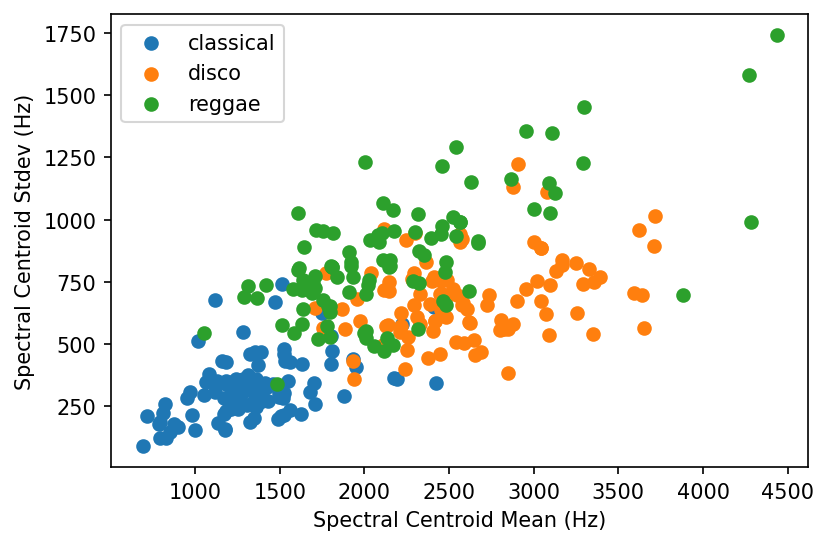

In [4]:
plt.figure(dpi=150)
plt.scatter(classical[:,0], classical[:,1], label="classical")
plt.scatter(disco[:,0], disco[:,1], label="disco")
plt.scatter(reggae[:,0], reggae[:,1], label="reggae")
plt.xlabel('Spectral Centroid Mean (Hz)')
plt.ylabel('Spectral Centroid Stdev (Hz)')
plt.legend()

**1a**

Use sckit-learn to report the 10-fold cross-validation classification accuracy for a linear support vector machine and a naive bayes classifier trained on the two features calculated above (mean centroid and std centroid) to predict the three genres. Show the confusion matrix for each case. 

(Minimum: 1 point)

In [5]:
svm = LinearSVC(max_iter=1500)
nb = MultinomialNB()

In [6]:
X = np.append(classical, disco, 0)
X = np.append(X, reggae, 0)

y_classical = np.empty(classical.size)
y_classical.fill(0)
y_disco = np.empty(disco.size)
y_disco.fill(1)
y_reggae = np.empty(reggae.size)
y_reggae.fill(2)

y = np.append(y_classical, y_disco, 0)
y = np.append(y, y_reggae, 0)

In [40]:
kf = KFold(n_splits=10, shuffle=True)
kf.split(X, y)

def evaluate(clf, X, y):
    conf_matrix = []
    accuracy = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        fit = clf.fit(X_train, y_train)
        y_pred = fit.predict(X_test)

        conf_matrix.append(confusion_matrix(y_test, y_pred))
        accuracy.append(accuracy_score(y_test, y_pred))

    return conf_matrix, np.mean(accuracy)
    
evaluate(nb, X, y)

([array([[16,  4],
         [ 2,  8]]),
  array([[17,  2],
         [ 1, 10]]),
  array([[21,  1],
         [ 3,  5]]),
  array([[15,  3],
         [ 2, 10]]),
  array([[14,  3],
         [ 3, 10]]),
  array([[18,  5],
         [ 0,  7]]),
  array([[21,  3],
         [ 1,  5]]),
  array([[14,  4],
         [ 1, 11]]),
  array([[16,  2],
         [ 1, 11]]),
  array([[21,  0],
         [ 1,  8]])],
 0.8600000000000001)

In [41]:
scaler = sklearn.preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
evaluate(svm, X, y)

([array([[15,  2],
         [ 3, 10]]),
  array([[18,  2],
         [ 3,  7]]),
  array([[16,  1],
         [ 1, 12]]),
  array([[20,  4],
         [ 0,  6]]),
  array([[19,  3],
         [ 3,  5]]),
  array([[16,  1],
         [ 1, 12]]),
  array([[22,  2],
         [ 2,  4]]),
  array([[19,  3],
         [ 2,  6]]),
  array([[17,  3],
         [ 2,  8]]),
  array([[16,  1],
         [ 4,  9]])],
 0.8566666666666667)

**1b**

Compute the MFCCs for each recording using the default settings of librosa. Then summarize the entire recording by taking the mean of the MFCCs across the recording as well as the mean and standard deviation across each recording. The resulting configurations will be just the mean (20 features per recording) and the mean and std (40 features per recording). Report on the 10-fold cross-validation classification accuracy and confusion matrix for these two configurations using the linear support vector machine and naive bayes classifier.

(Minimum: 1 point)

In [58]:
from librosa.feature import mfcc

def compute_folder2(folder):
    results = []
    mfccs = []
    files = []
    for filename in os.listdir(folder):
    
        # Load audio file
        path = os.path.join(folder, filename)
        audio, sr = librosa.load(path)
        files.append(path)
        
        # Compute MFCC
        mfcc_feat = mfcc(audio, sr)
        
        # Compute mean and standard deviation across frames
        features = np.append(np.mean(mfcc_feat, axis=1), np.std(mfcc_feat, axis=1))
        mfccs.append(np.mean(mfcc_feat, axis=1))
        results.append(features)

    return np.array(results), np.array(mfccs), files

cc, c, files_c = compute_folder2('./a4_resources/GTZAN/classical')
dd, d, files_d = compute_folder2('./a4_resources/GTZAN/disco')
rr, r, files_r = compute_folder2('./a4_resources/GTZAN/reggae')

files = []
files.extend(files_c)
files.extend(files_d)
files.extend(files_r)

X = np.append(c, d, 0)
X = np.append(X, r, 0)

XX = np.append(cc, dd, 0)
XX = np.append(XX, rr, 0)


#### 40 features (20 means + 20 stds)
1. Naive Bayes

In [59]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
evaluate(nb, X, y)

([array([[18,  2],
         [ 3,  7]]),
  array([[16,  3],
         [ 2,  9]]),
  array([[13,  1],
         [ 8,  8]]),
  array([[17,  6],
         [ 0,  7]]),
  array([[16,  4],
         [ 3,  7]]),
  array([[10,  8],
         [ 3,  9]]),
  array([[19,  5],
         [ 3,  3]]),
  array([[16,  5],
         [ 3,  6]]),
  array([[16,  2],
         [ 2, 10]]),
  array([[22,  1],
         [ 2,  5]])],
 0.78)

2. SVM

In [98]:
svm = LinearSVC(max_iter=2500)
scaler = sklearn.preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
evaluate(svm, X, y)

([array([[20,  2],
         [ 3,  5]]),
  array([[17,  1],
         [ 4,  8]]),
  array([[18,  4],
         [ 2,  6]]),
  array([[22,  1],
         [ 2,  5]]),
  array([[14,  4],
         [ 4,  8]]),
  array([[16,  1],
         [ 5,  8]]),
  array([[14,  3],
         [ 2, 11]]),
  array([[21,  2],
         [ 1,  6]]),
  array([[17,  2],
         [ 6,  5]]),
  array([[16,  5],
         [ 2,  7]])],
 0.8133333333333335)

#### 20 features (20 means)

1. Naive Bayes

In [76]:
evaluate(nb, XX, y)

([array([[17,  3],
         [ 1,  9]]),
  array([[13,  7],
         [ 1,  9]]),
  array([[16,  3],
         [ 2,  9]]),
  array([[20,  1],
         [ 5,  4]]),
  array([[23,  2],
         [ 0,  5]]),
  array([[16,  3],
         [ 1, 10]]),
  array([[12,  1],
         [ 1, 16]]),
  array([[17,  2],
         [ 3,  8]]),
  array([[21,  2],
         [ 1,  6]]),
  array([[18,  3],
         [ 0,  9]])],
 0.86)

2. SVM

In [93]:
svm = sklearn.linear_model.SGDClassifier() # linear classifier with stochastic gradient descent
evaluate(svm, XX, y)

([array([[22,  0],
         [ 7,  1]]),
  array([[16,  1],
         [ 2, 11]]),
  array([[ 6, 11],
         [ 0, 13]]),
  array([[23,  1],
         [ 2,  4]]),
  array([[20,  1],
         [ 3,  6]]),
  array([[18,  3],
         [ 3,  6]]),
  array([[ 9, 11],
         [ 0, 10]]),
  array([[18,  0],
         [ 5,  7]]),
  array([[18,  5],
         [ 1,  6]]),
  array([[16,  1],
         [ 2, 11]])],
 0.8033333333333333)

**1c**

Use t-SNE$^1$  to reduce the dimensionality of **the 300 by 40 feature matrix of mean and std mfccs** to a 300 by 2 feature matrix. Visualize the corresponding scatter plot with coloring of the points based on genre. How does the visual separation/overlap compare to the scatter plot of just the centroid? Run the 10-fold cross-validation classification accuaracy and show a confusion matrix for the same configurations as the full feature set, but now using only the 2 dimensions returned from t-SNE. How much accuracy is lost compared results from the previous question?

(Expected: 1 point)

$^1$https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [61]:
X_embedded = TSNE(n_components=2).fit_transform(XX)

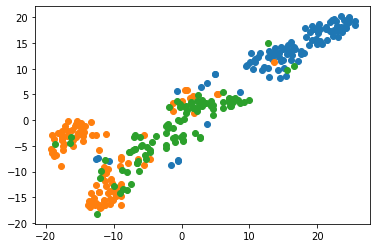

In [99]:

X_classical = X_embedded[0:99]
X_disco = X_embedded[100:199]
X_reggae = X_embedded[200:299]

#plt.scatter(X_embedded.T[0], X_embedded.T[1])

plt.scatter(X_classical.T[0], X_classical.T[1])
plt.scatter(X_disco.T[0], X_disco.T[1])
plt.scatter(X_reggae.T[0], X_reggae.T[1])

plt.show()

In [100]:
evaluate(nb, X_embedded, y)

([array([[16,  4],
         [ 3,  7]]),
  array([[16,  3],
         [ 4,  7]]),
  array([[18,  2],
         [ 4,  6]]),
  array([[21,  1],
         [ 1,  7]]),
  array([[17,  6],
         [ 2,  5]]),
  array([[15,  1],
         [ 4, 10]]),
  array([[20,  0],
         [ 3,  7]]),
  array([[22,  2],
         [ 3,  3]]),
  array([[16,  4],
         [ 2,  8]]),
  array([[14,  2],
         [ 5,  9]])],
 0.8133333333333332)

In [105]:
svm = sklearn.linear_model.SGDClassifier() 
evaluate(svm, X_embedded, y)

([array([[9, 9],
         [7, 5]]),
  array([[13,  8],
         [ 4,  5]]),
  array([[22,  1],
         [ 7,  0]]),
  array([[12,  6],
         [ 9,  3]]),
  array([[20,  1],
         [ 7,  2]]),
  array([[13,  8],
         [ 4,  5]]),
  array([[13, 11],
         [ 3,  3]]),
  array([[11,  7],
         [ 6,  6]]),
  array([[11,  6],
         [ 9,  4]]),
  array([[10,  9],
         [ 5,  6]])],
 0.5766666666666667)

#### Answer

The previous classifiers achieved 85% accuracy, so there is is some loss of accuracy (between 1-3%), but the classifier is still ~80% accurate for the Naive Bayes. The Linear SVM doesn't do so well with only 55-60% accuracy. 

**1d**

Let's forget about the genre labels and do some unsupervised learning. In this question we'll perform clustering on the two-dimensional results from t-SNE using K-Means$^1$. Pretend that you forgot that the files in the dataset are actually from three different genres and experiment with a few different values for number of clusters. Plot the results of clustering using three different choices for n_clusters. Make sure to plot each sample colored by the label assigned to it by K-Means. What value for n_clusters gives you the best result in your opinion? How does your plot compare to the results from the previous question?

Now, randomly select three points from two different clusters and play the associated audio files (6 in total). This is where keeping track of the audio file names during audio feature extraction would have been helpful (see code comment in the compute folder function above). 

Comment on the similarities between the audio files from the same clusters - do they sound like they are from the same genre? Does it make sense that they were clustered together?

(Expected: 1 point)

$^1$https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

#### 4 clusters

In [288]:
kmeans = KMeans(n_clusters=4).fit(X_embedded)

In [307]:
X_a = np.empty((1, 2))
X_b = np.empty((1, 2))
X_c = np.empty((1, 2))
X_d = np.empty((1, 2))

y_pred = kmeans.predict(X_embedded)

def outliers(arr):
    lim = 100
    if (arr[0]) > lim: return True
    if (arr[1]) > lim: return True
    if (arr[0]) < -lim: return True
    if (arr[1]) < -lim: return True

for i in range(len(X_embedded)):
    if (y_pred[i] == 0 and not outliers(X_embedded[i])):
        X_a = np.vstack((X_a, X_embedded[i]))
    elif(y_pred[i] == 1 and not outliers(X_embedded[i])):
        X_b = np.vstack((X_b, X_embedded[i]))
    elif(y_pred[i] == 2 and not outliers(X_embedded[i])):
        X_c = np.vstack((X_c, X_embedded[i]))
    elif(y_pred[i] == 3 and not outliers(X_embedded[i])):
        X_d = np.vstack((X_d, X_embedded[i]))
        



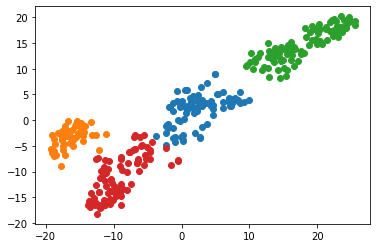

In [308]:
plt.scatter(X_a.T[0], X_a.T[1])
plt.scatter(X_b.T[0], X_b.T[1])
plt.scatter(X_c.T[0], X_c.T[1])
plt.scatter(X_d.T[0], X_d.T[1])

plt.show()

#### 2 clusters

In [275]:
kmeans = KMeans(n_clusters=2).fit(X_embedded)

In [280]:
X_classical = np.empty((1, 2))
X_disco = np.empty((1, 2))
X_reggae = np.empty((1, 2))

y_pred = kmeans.predict(X_embedded)

for i in range(len(X_embedded)):
    if (y_pred[i] == 0 and not X_embedded[i][1] > 50):
        X_classical = np.vstack((X_classical, X_embedded[i]))
    elif(y_pred[i] == 1 and not X_embedded[i][1] > 50):
        X_disco = np.vstack((X_disco, X_embedded[i]))
        

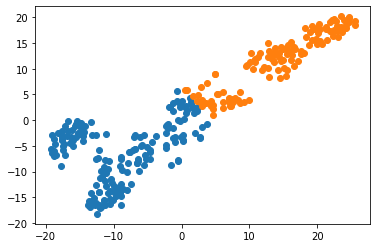

In [281]:
plt.scatter(X_classical.T[0], X_classical.T[1])
plt.scatter(X_disco.T[0], X_disco.T[1])
plt.show()

#### 3 clusters

In [272]:
kmeans = KMeans(n_clusters=3).fit(X_embedded)

In [181]:
X_classical = np.empty((1, 2))
X_disco = np.empty((1, 2))
X_reggae = np.empty((1, 2))

y_pred = kmeans.predict(X_embedded)

for i in range(len(X_embedded)):
    if (y_pred[i] == 0 and not (X_embedded[i][0] > 50 or X_embedded[i][0] < -50)):
        X_classical = np.vstack((X_classical, X_embedded[i]))
    elif(y_pred[i] == 1 and not (X_embedded[i][0] > 50 or X_embedded[i][0] < -50)):
        X_disco = np.vstack((X_disco, X_embedded[i]))
    elif(y_pred[i] == 2 and not (X_embedded[i][0] > 50 or X_embedded[i][0] < -50)):
        X_reggae = np.vstack((X_reggae, X_embedded[i]))
        

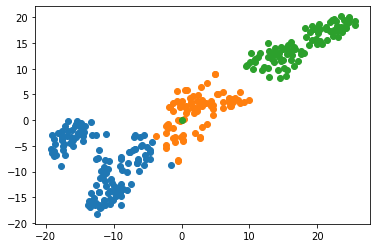

In [182]:
plt.scatter(X_classical.T[0], X_classical.T[1])
plt.scatter(X_disco.T[0], X_disco.T[1])
plt.scatter(X_reggae.T[0], X_reggae.T[1])
plt.show()

In [123]:
y_idx = [4, 17, 40, 103, 114, 132]
songs = y_pred[y_idx]
print('Three songs in 0 (classical), and three songs in 2 (reggae): ', songs)


#track_data, sr = sf.read(files[5])
#sd.play(track_data, sr)

#track_data, sr = sf.read(files[17])
#sd.play(track_data, sr)

#track_data, sr = sf.read(files[40])
#sd.play(track_data, sr)

#track_data, sr = sf.read(files[103])
#sd.play(track_data, sr)

#track_data, sr = sf.read(files[114])
#sd.play(track_data, sr)

#track_data, sr = sf.read(files[132])
#sd.play(track_data, sr)

Three songs in 0 (classical), and 3 songs in 2:  [0 0 0 2 2 2]


#### Answer

The plots show that 4 clusters would be the way to go, even though there are only 3 classes in the original database. This is probably becasue reggae and disco are quite similar genres.

The clustered classical music songs (at 4, 17, and 40) are clearly all classical music, all very similar to each other.

The reggae songs (103, 114, 132) are also similar to one another, they all have a clearly distinguishable beat, theyre clearly different from songs in the classical cluster. 

### Question 2

This question will look at Naive Bayes classification with song lyrics. George covers material pretty much identical to this question in the first video of the Machine Learning for MIR Kadenze course, which you can use if you need to review this material before completing the questions.

Our goal will be to build a simple Naive Bayes classifier for the MSD dataset, which uses lyrics to classify music into genres. More complicated approaches using term frequency and inverse document frequency weighting and many more words are possible but the basic concepts are the same. The goal is to understand the whole process, so **do not use existing machine learning packages** but rather build the classifier from “scratch”.

We are going to use the musicXmatch$^1$ dataset which is a large collection of song lyrics in bag-of-words format for some of the tracks contained in the Million Song dataset (MSD). 

The corresponding genre annotations, for some of the song in the musicXmatch dataset, is provided by the MSD Allmusic Genre Dataset$^2$.

We are going to use a reduced version of musicXmatch. 
3 genres: “Rap”, “Pop Rock”, and “Country”. 

The resulting genre annotated dataset is obtained by an intersection of musicXmatch and MAGD, where we select **1000 instances of each genre**, such that the three classes are balanced and easy to handle. In addition, we also reduce the cardinality of the dictionary of words used for the bag-of words lyrics representation (originally equal to 5000), to the 10 best words for each genre. Intuitively, the best words are the most frequent words for a particular genre that are not frequent among all the genres$^3$

$^1$https://labrosa.ee.columbia.edu/millionsong/musixmatch

$^2$http://www.ifs.tuwien.ac.at/mir/msd/partitions/msd-MAGD-genreAssignment.cls

$^3$The best genre words maximize the Term Frequency (TF) and Inverse Document Frequency (IDF) product. More details available at https://en.wikipedia.org/wiki/Tf-idf

The resulting dictionary of words is:

| Genre   |      |      |       |       |      |      |       |      |       |       |
|---------|------|------|-------|-------|------|------|-------|------|-------|-------|
| rap     | de   | hood | ya    | und   | yall | ich  | fuck  | shit | yo    | bitch |
| rock    | end  | wait | again | light | eye  | noth | lie   | fall | our   | away  |
| country | gone | good | night | blue  | home | long | littl | well | heart | old   |

For answering this question we provide you with:

- **data.npy** – the three genres dataset (not binarized - you will need to binarize)
- **labels.npy** – the genre labels where Rap=12, Pop Rock=1, and Country=3
- **dictionary.pickle** – the full 5000 words dictionary
- **words.npy** – the 30 best word indexes with respect to the full dictionary
- **tracks.pickle** – the track IDs of songs used (not needed for assignment, but included for those interested).

This is available on BrightSpace in the data folder in the assignment resources download. You will need to use python pickle and numpy load to load the pickle and npy files respectively.

**2a**

Write code that calculates the probabilities for each dictionary word given the genre. For the purposes of this assignment we are considering only the tracks belonging to the three genres: Rap, Rock/Pop, Country. Use add-one additive smoothing$^1$ to handle the case that there is no instance of a particular word in a genre. 

(Minimum 1pt)

$^1$https://en.wikipedia.org/wiki/Additive_smoothing


In [124]:
with open('./a4_resources/data/dictionary.pickle', 'rb') as pickle_file:
    dictionary = pickle.load(pickle_file)
    
dictionary = pd.DataFrame(dictionary)
dictionary

,0
0,i
1,the
2,you
3,to
4,and
...,...
4995,santo
4996,pe
4997,gee
4998,colleg


In [125]:
words = np.load('./a4_resources/data/words.npy')
words = pd.DataFrame(words)
words

,0
0,41
1,1948
2,169
3,217
4,1036
5,188
6,260
7,454
8,173
9,728


In [126]:
data = np.load('./a4_resources/data/data.npy')
data = pd.DataFrame(data)
data

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0,0,0,0,1,0,1,3,0,0,...,1,2,2,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,8,0,0,0,0
2,0,1,5,0,0,0,1,3,4,0,...,0,0,1,0,0,0,0,0,0,0
3,0,5,0,0,0,0,2,4,8,1,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,2,0,2,...,0,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,1,1,1
2996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,0,1,0
2997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2998,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,4,0,0


In [127]:
labels = np.load('./a4_resources/data/labels.npy')
labels = pd.DataFrame(labels)
labels

,0
0,12
1,12
2,12
3,12
4,12
...,...
2995,3
2996,3
2997,3
2998,3


In [129]:
def probability(c, data, labels, words, reverse=False):
    
    num_docs = data.shape[0]
    c = int(c)
    
    alpha = 1 # alpha numerator
    alpha_d = dictionary.shape[0] # alpha denominator

    sums_c = {} # 30
    
    for i in range(words.shape[0]):
        k = words.iloc[i][0]
        sums_c[k] = alpha

    for i in range(words.shape[0]): # for each word in words [30]
        for j in range(num_docs): # for each word in doc-row (1000)
            # num of times word X appears anywhere under CLASS
            if (int(labels.iloc[j][0]) != c):
                continue
            k = words.iloc[i][0]
            
            if (data.iloc[j][i] != 0):
                sums_c[k] += data.iloc[j][i]

    sums_all = {}
    for i in range(words.shape[0]):
        k = words.iloc[i][0]
        sums_all[k] = alpha_d
    
    for i in range(words.shape[0]): # for each word in words [30]
        for j in range(num_docs): # for each word in doc-row (1000)
            # num of times word X appears anywhere under CLASS            
            k = words.iloc[i][0]
            sums_all[k] += data.iloc[j][i]
            
    sums = {k: sums_c[k]/sums_all[k] for k in sums_c}
    
    return sums

**2b**

<font color='grey'>One can consider the Naive Bayes classifier a generative model that can generate binary feature vectors using the associated probabilities from the training data. The idea is similar to how we do direct sampling in Bayesian Networks and depends on generating random number from a discrete distribution (the unifying underlying theme of this assignment question). </font>

Describe how you would generate random genre “lyrics” consisting solely of the words from the dictionary using your model. Code that and show 5 examples of randomly generated tracks for each of the three genres: Rap, Rock pop, and Country; each example should consist of a subset of the words in the dictionary. 

(Minimum: 1 point)

In [ ]:
def probability1(c, data, labels, dictionary, words, reverse=False):
    
    num_words = data.shape[0]
    c = int(c)
    num_docs = len([x for x in labels[0] if x == c])
    
    if (reverse):
        num_docs = labels.shape[0] - num_docs
    
    alpha = 1
    alpha_d = dictionary.shape[0]

    sums_c = np.zeros(dictionary.shape[0])
    
    for i in range(num_words): # for each word in doc-row (1000)
        for j in range(words.shape[0]): # for each word in words [30]
            # num of times word X appears anywhere under CLASS
            if (reverse == False and int(labels.iloc[j][0]) != c):
                continue
            elif (reverse == True and int(labels.iloc[j][0]) == c):
                continue
            
            k = words.iloc[j][0]
            sums_c[k] += data.iloc[i][j]
    
    sums_c = [x + alpha for x in sums_c]
    sums_c = np.array(sums_c)
    
    sums_all = np.zeros(dictionary.shape[0])
    
    for i in range(num_words): # for each word in doc-row (1000)
        for j in range(words.shape[0]): # for each word in words [30]
            # num of times word X appears anywhere under CLASS            
            k = words.iloc[j][0]
            sums_all[k] += data.iloc[i][j]
            
    sums_all = [x + alpha_d for x in sums_all]
    sums_c = sums_c / sums_all
    print(np.mean(sums_c))
    
    return np.array([sums_c, dictionary[0]])

In [198]:
def get_genre(genre):
    genres = [(1, 'rock'), (3, 'country'), (12, 'rap')]
    if genre in [1, 3, 12]:
        g = [x[1] for x in genres if x[0] == genre]
        return g[0]
    
    elif genre in ['rock', 'country', 'rap']:
        g = [x[0] for x in genres if x[1] == genre]
        return g[0]

get_genre(12)

'rap'

In [200]:
def generate(probabilities):
    length = 50
    dist = probabilities[0].astype(np.float)
    words = probabilities[1]
    out = []
    
    for i in range(length):
        p = np.random.choice(words, 
                             p=dist/dist.sum())
        out.append(p)
    
    return np.array(out)

#### Rap

In [201]:
rap = probability1(get_genre('rap'), data, labels, dictionary, words, False)

songs = []

for i in range(5):
    s = generate(rap)
    songs.append(' '.join([str(elem) for elem in s]))
    
songs

0.001239506885445381


['heart long home long long night our light ya yo night our long bitch ya yall light und bitch de ya lie our good de ich night long our our ich heart und ya old yo night away lie our hood long home fuck fuck well yo again eye night',
 'bitch away de good well eye away long ya yo gone ich away yo night bitch light night littl de noth our well heart end wait fuck eye de away well eye night again eye yo heart littl good eye wait fall fuck away fall eye shit long light littl',
 'good night light lie again littl gone our ya fuck away yo eye yo night lie good night old littl long heart old our de yo away hood old und away littl ich night yall well lie our night night again ich lie shit night heart de again de wait',
 'night und wait well well gone littl long long fuck noth again ich long yall old ya eye hood yall night again ya heart our again wait heart fuck night fall fuck blue blue eye end ich light fall eye ya again bitch littl again home ya night fuck lie',
 'blue noth fall night wait n

#### Rock pop

In [181]:
rock = probability1(get_genre('rock'), data, labels, dictionary, words, False)

songs = []

for i in range(5):
    s = generate(rap)
    songs.append(' '.join([str(elem) for elem in s]))
    
songs

['lie ich ya night fuck ya dare gone yo littl end histoir bitch light home de diss display noth heart our long fuck long littl away away again yo yo away home littl gone away ich heart light yo well fuck night long eye modo again ya yall wait rope',
 'heart wer death home home rave yo yo ich fuck bli away weg light away fall slick noth bitch well willst eye wait noth assum fall end bitch light long de yall shit night yall littl heart our heart gone und yo away heart old littl fall shit yall fuck',
 'home well fall ya fuck good lie our the axe seek de yall wait heart fuck ya blue trick noth heart wait eye yall ich yall bet night good fuck quello choic littl und heart light dah littl steadi ich littl noth yo gone heart night de old heart end',
 'lie wait blue eye heart good hood home de heart away ich again heart lie light littl yo pretti end good niemal night yall again ich noth de de long heart good fall de soll jewel old long good home ya lie de lie de again und fold good heart',
 'ki

#### Country

In [182]:
country = probability1(get_genre('country'), data, labels, dictionary, words, False)

songs = []

for i in range(5):
    s = generate(rap)
    songs.append(' '.join([str(elem) for elem in s]))
    
songs

['bitch yo nu fuck de de kneel old old light intro long littl littl lie che littl mort weird noth noth hood good hood alway away ya eye heart well remov home well night yo knight prima ich night de gone und ya littl well fuck away gone well de',
 'our littl blue littl bitch wait well well yo shit end good long wait bitch again lie long home adiÃ³ shit blue ich our dust shit fuck eye again fuck yall shit shit night 16 ya heart lane de fall bitch good fall ya away littl noth good night shout',
 'yo fall fuck wait yall raindrop our long further well away well well gone fall yall heart gone night und night night heart old night gone de again innoc pop shit lie noth shit home tooth de closet night wait heart home again again fuck blue ya away bitch well',
 'old home home garbag gone stake fall end blue lie de de sil gone night gone noth fall gone shit de old away home de ich night eye night end de gone fall lie de bitch de good ich gone night night end ogni shit ya eye shit und fuck',
 'vit

**2c**

Explain how these probability estimates can be combined to form a Naive Bayes classifier. Code it and calculate the classification accuracy and confusion matrix that you would obtain using the whole data set for both training and testing. **Do not use any libraries such as scikit-learn but write the code directly.** 

(Expected: 2 point)

#### Helpers

In [130]:
def calc_prior(labels, c):
    classes, counts = np.unique(labels[0], return_counts=True)
    cls_count = dict(zip(classes, counts))
    
    c = int(c)
    c = cls_count.get(c)
    prior = c / labels.shape[0]
        
    return prior

In [131]:
def calc_class_prob(c, doc, model, words):
    
    c = int(c)
    
    prior = model[c][0]
    probs_y = model[c][1]
    
    P_y = np.log(prior)
    
    for k in range(len(doc)):
        if isinstance(doc[0], str):
            i = np.where(probs_y == doc[k].lower())
        else:
            i = words.iloc[k][0]
        
        p = probs_y[i]
        
        if (doc[k] == 0):
            continue      
        
        p = np.log(float(p))*doc[k]
        P_y += p
        
    return P_y

In [132]:
def predict_doc(doc, model, words):
    num_classes = list(model.keys())
    
    out = []
    
    for c in num_classes:
        p = calc_class_prob(c, doc, model, words)
        out.append((p, c))
    
    prediction = max(out, key=lambda item:item[0])[1]

    return prediction

In [134]:
def naive_bayes_train(X, y, words):
    classes, unique = np.unique(y, return_counts=True)
    model = {1: [], 3: [], 12: []}

    for c in classes:
        prior = calc_prior(y, c)
        model[c].append(prior)
        probs = probability(c, X, y, words, False)
        model[c].append(probs)
        
        
    return model

In [135]:
def naive_bayes_pred(X, model):
    predictions = []
    for doc in X:
        genre = predict_doc(doc, model)
        predictions.append(genre)
        
    return predictions

#### Answer

Naive Bayes classifier using probability() function:
 - the ```probability()``` function takes in "class" as one of the argumentsa and returns an array of words 30 from words.np with their probablities ($P(word|class)$)
 
 - ```naive_bayes_train()``` takes in X and y (data and labels) and using ```probability()``` returns a model (an array of probabilities for each of the 3 classes + prior probability for each class)
 
 - naive_bayes_pred() calculates the likelhood of a doc for each class (```using predict_doc()``` and ```calc_class_pred helper()``` functions) like so:
     - $probability = P_{prior} + log(P_{w1}) n + log(P_{w2}) n + ... + log(P_{w30}) n$
     
     where $w$ is a word in ```words.npy``` and $n$ is the number of times $w$ occurs in a given class
     
     -  the "winning" class is the class with the highest probability score
     
Source for probability calculation: https://nlp.stanford.edu/IR-book/pdf/13bayes.pdf

**2d**

Read the Wikipedia page about cross-validation in statistics$^1$. Calculate the classification accuracy and confusion matrix using the k−fold cross-validation, where k = 10. Note that you will need to generate your own splits. **Do not use any libraries such as scikit-learn but write the code directly.**

(Expected: 2 points)

$^1$https://en.wikipedia.org/wiki/Cross-validation_(statistics)


In [137]:
def kfold_idx(k, X):
    num_docs = len(X)
    
    docs_dist = np.arange(0, num_docs)
    np.random.shuffle(docs_dist)
    
    folds = []
    fold_len = int(num_docs/k)

    for i in range(k):
        fold = np.array(docs_dist[i*fold_len:(i + 1)*fold_len])
        folds.append(fold)
        
    folds = np.array(folds)
    
    folds_combs = []
    
    for i in range(k):
        folds_combs.append(np.roll(folds, i, 0))
        
    return folds_combs

In [138]:
def kfold_evaluate(k, X, y, words):
    kf = kfold_idx(k, X)
    
    accuracies = []
    matrices = []
    
    count = 1
    for e in kf:
        
        print("Cross validating fold ", count)
        count += 1
        test_idx = e[0].tolist()
        train_idx = e[1:k].flatten()
        train_idx = train_idx.tolist()

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        y_test = y_test.to_numpy().flatten()
        
        model = naive_bayes_train(X_train, y_train, words)
        
        y_pred = []
        for i in range(len(X_test)):
            y_pred.append(predict_doc(X_test.iloc[i], model, words))
    
        accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
        print(accuracy)
        accuracies.append(accuracy)
        
        matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
        print(matrix)
        matrices.append(matrix)
    
    return accuracies, matrices

In [139]:
accuracies, matrices = kfold_evaluate(10, X, y, words)

Cross validating fold  1
0.6933333333333334
[[44 45 17]
 [13 76  4]
 [ 6  7 88]]
Cross validating fold  2
0.72
[[59 29 12]
 [21 72  6]
 [ 6 10 85]]
Cross validating fold  3
0.68
[[46 33 18]
 [22 78  4]
 [10  9 80]]
Cross validating fold  4
0.6533333333333333
[[38 45 15]
 [23 70  6]
 [ 8  7 88]]
Cross validating fold  5
0.67
[[54 50 12]
 [17 71  2]
 [ 8 10 76]]
Cross validating fold  6
0.6633333333333333
[[52 33 18]
 [21 67  7]
 [10 12 80]]
Cross validating fold  7
0.67
[[44 33 13]
 [30 71  4]
 [11  8 86]]
Cross validating fold  8
0.7233333333333334
[[51 27  9]
 [29 78  2]
 [ 8  8 88]]
Cross validating fold  9
0.6966666666666667
[[55 33 21]
 [19 74  3]
 [ 9  6 80]]
Cross validating fold  10
0.66
[[43 38 13]
 [30 71  9]
 [ 3  9 84]]


#### Avg accuracy

In [206]:
np.mean(accuracies)

0.6856666666666665